<a href="https://colab.research.google.com/github/vikrantb/finance_innovation/blob/main/DiscountedCashFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Understanding the effect of financial model parameters on the Net Present value of the NetPhone project**

In [ ]:
#@title
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import interpolate


In [ ]:
#@title
def add_data(df, data, name):
  df.loc[len(df)] = data
  #Rename Index
  df.rename({df.index[-1]: name}, inplace=True)
  return df



In [ ]:
#@title
def fcn_get_npv(cost_of_capital=2, final_market_penetration=20):

  #Set variables
  # final_market_penetration = 20 #@param {type:"slider", min:0, max:100, step:1}
  num_years = 5

  market_size = 100

  market_size_vals = market_size * np.ones((1,num_years))
  yearly_penetration_rate = np.linspace(0,final_market_penetration, num_years)
  cumulative_units_sold  = (yearly_penetration_rate/100) * market_size_vals;


  vals = np.vstack((market_size_vals,
                    yearly_penetration_rate, 
                    cumulative_units_sold))

  # Create the names:
  list_names=[]
  for i in range(num_years):
    list_names.append(f"Year_{i}")

  row_names = ["Market Size","Market Penetration Rate", "Cumulative Units Sold"]
  # print(list_names)

  df = pd.DataFrame(vals)
  df.columns = list_names
  df.index = row_names
  # print("Resulting Discounted Cash Flow data:\n")

  #Annual units sold
  annual_units_sold = np.concatenate((np.array([0,]), np.diff(cumulative_units_sold)[0]))

  df.loc[len(df)] = annual_units_sold
  #Rename Index
  df.rename({df.index[-1]: 'Annual Units Sold'}, inplace=True)


  #Avg Selling price / unit
  avg_price = 62.5
  avg_price_vals = avg_price * np.ones(num_years)
  # print(avg_price_vals)

  df.loc[len(df)] = avg_price_vals
  #Rename Index
  df.rename({df.index[-1]: 'Average Price/Unit'}, inplace=True)


  #Qcom royalty share percent
  qcom_royalty_percent = 20
  qcom_royalty_vals = (qcom_royalty_percent/100) * np.ones(num_years)
  # print(rvals)

  df.loc[len(df)] = qcom_royalty_vals
  #Rename Index
  df.rename({df.index[-1]: 'Qcom royalty share Percent'}, inplace=True)

  #Netphone sales
  netphone_sales = annual_units_sold * avg_price_vals* qcom_royalty_vals
  # print(netphone_sales)

  df.loc[len(df)] = netphone_sales
  #Rename Index
  # df.rename(index={len(df)-1: 'Netphone Sales'})
  df.rename({df.index[-1]: 'Netphone Sales'}, inplace=True)


  #Cannibalization Rate
  cannibalization_rate = 40

  #Lost Units
  cann_units = -1*(cannibalization_rate/100) * annual_units_sold
  # print(f'CannibalizeUnits: {cann_units}')
  # Avg qcom price/unit
  avg_qcom_cann_unit_cost = 5

  # cannibalized sales
  cann_sales = cann_units * avg_qcom_cann_unit_cost

  # Total sales
  total_sales = netphone_sales + cann_sales
  # print(f'total_sales: {total_sales}')
  df = add_data(df, total_sales, "Total Sales")


  # Cost of sales
  NetPhone_unit_cost = 6
  NetPhone_COGS = -1*NetPhone_unit_cost * annual_units_sold

  OldProduct_unit_cost = 3
  Old_COGS = -1*OldProduct_unit_cost * cann_units

  cost_of_sales = NetPhone_COGS + Old_COGS
  # print(f'NetPhone_COGS:{NetPhone_COGS}, Old_COGS:{Old_COGS}, cost_of_sales: {cost_of_sales}')

  df = add_data(df, cost_of_sales, "Cost Of Sales")

  #Gross Profit
  gross_profit = total_sales + cost_of_sales
  df = add_data(df, gross_profit, "Gross Profit")

  # HW Expense
  hw_expense = -10

  # SW Expense
  sw_expense = -12.5

  #Total Operating Expense
  total_rnd_expense = hw_expense + sw_expense
  yearly_rnd_expense = np.zeros(num_years)
  yearly_rnd_expense[0] = total_rnd_expense
  df = add_data(df, yearly_rnd_expense, "R&D Expense")

  #SGA
  sga_expense = -0.5
  yearly_sga_expense =  -2.5* np.ones(num_years)
  yearly_sga_expense[0] = sga_expense
  df = add_data(df, yearly_sga_expense, "SG&A Expense")

  lab_equipment = -20
  capex = np.zeros(num_years)
  capex[0] = lab_equipment
  df = add_data(df, capex, "Capex")
  # print(f"Capex: {capex}")

  #Depreciation
  depreciation = np.ones(num_years) * (lab_equipment/ (num_years-1))
  depreciation[0] = 0
  df = add_data(df, depreciation, "Depreciation")

  # Operating Income/ EBIT
  ebit = gross_profit + yearly_rnd_expense + yearly_sga_expense + depreciation
  df = add_data(df, ebit, "EBIT")

  # Taxes 

  tax_rate = 40
  yearly_taxes = -1*(tax_rate/100) * ebit
  df = add_data(df, yearly_taxes, "Taxes")

  # Net Income
  net_income = ebit + yearly_taxes
  df = add_data(df, net_income, "Net Income")


  #Working Capital Forecast
  # Receivables (% Sales)
  receivables = 16
  yearly_receivables = (receivables/100) * total_sales
  df = add_data(df, yearly_receivables, "Receivables")

  # Payables (% COGS)
  payables = 10
  yearly_payables = (payables/100) * cost_of_sales
  df = add_data(df, yearly_payables, "Payables")

  # # Inventory (% next year COGS)
  # inventory = 0 #@param {type: "slider"}
  # yearly_inventory = -1*(inventory/100) * total_sales

  # #Net Working Capital
  df['Year_5']= 0
  # print(df)

  net_working_capital = df.loc['Receivables'] + df.loc['Payables']
  # print(net_working_capital)
  diff_nwc = np.zeros(num_years+1)

  diff_nwc[1:] = -1*np.diff(net_working_capital)
  # diff_nwc[num_years]=0
  # print(diff_nwc)

  df = add_data(df, net_working_capital, "Net Working Capital")

  # Free Cash Flow
  fcf = df.loc['EBIT'] + df.loc['Taxes'] - df.loc['Depreciation'] + df.loc['Capex'] + diff_nwc
  df = add_data(df, fcf, "Free Cash Flow")

  # Cost of Capital
  # cost_of_capital = 2 #@param {type: "slider"}

  # Discount Factor
  discount_factor = np.ones(len(df.columns))
  for i in range(1, len(discount_factor)):
    discount_factor[i] = discount_factor[i-1] * (1 - (cost_of_capital/100))

  yearly_discount_factor = discount_factor
  df = add_data(df, yearly_discount_factor, "Discount Rate")
  # PV
  pv = df.loc['Free Cash Flow'] * df.loc['Discount Rate']
  df = add_data(df, pv, "Present Value")

  # NPV
  npv = np.sum(df.loc['Present Value'])
  # print(f"NPV: {npv}")

  return (df,npv)


  # # Plotting Results
  # xvals = np.linspace(0, num_years-1, num_years)
  # plt.figure(figsize=(10,8))
  # # plt.plot(xvals, df.iloc[-1])
  # ax = plt.gca()
  # ax.grid('on')
  # ax.set_xticks(xvals)
  # ax.set_xticklabels(list_names)

  # plt.title("Netphone NPV Calculations")
  # plt.legend(["Sales"])
  # print(df)

In [ ]:
#@title Check NPV calculations { run: "auto" }
final_market_penetration = 21 #@param {type:"slider"}
cost_of_capital = 2 #@param {type:"slider"}
(df,npv) = fcn_get_npv(cost_of_capital=cost_of_capital,
                       final_market_penetration=final_market_penetration)
# print(df)
print(f"Default NPV is:{npv:.2f} Million")

Default NPV is:35.92 Million


**What is the effect of changing Cost of Capital on the NPV of the NetPhone Project?**

NPV turns 0 at a Cost of Capital of: 24.28%


Text(0.5, 1.0, 'NPV vs Cost of Capital Calculations')

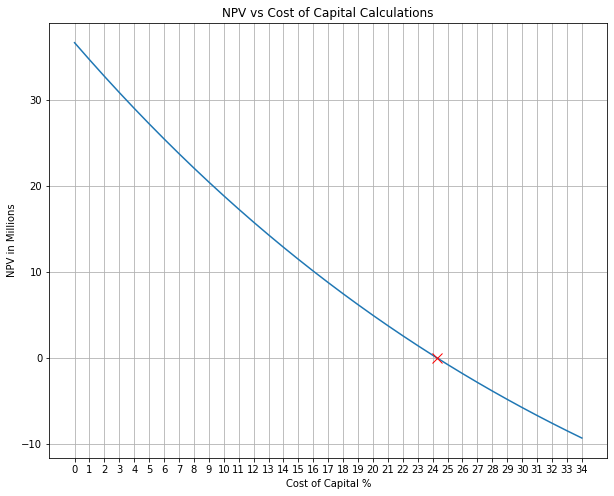

In [ ]:
#@title
array_npv = []
array_coc = []
for coc in range(0,35,1):
  (df,npv) = fcn_get_npv(cost_of_capital=coc)
  array_npv.append(npv)
  array_coc.append(coc)

# Find the 0 value
# Interpolation object
f = interpolate.interp1d(array_npv, array_coc, assume_sorted = False)
zero_npv_coc = f(0)   # use interpolation function returned by `interp1d`
print(f"NPV turns 0 at a Cost of Capital of: {zero_npv_coc:.2f}%")

# Plotting Results
plt.figure(figsize=(10,8))
plt.plot(array_coc, array_npv)

ax = plt.gca()
ax.grid('on')
# plt.hold('on')

ax.set_xticks(array_coc)
ax.set_xticklabels(array_coc)

#plot zero point where NPV turns 0
plt.plot(zero_npv_coc, 0, 'rx',markersize=10);
plt.xlabel('Cost of Capital %')
plt.ylabel('NPV in Millions')
plt.title("NPV vs Cost of Capital Calculations")
# plt.legend(["Sales"])



**What is the effect of change in market penetration rate to the NPV of NetPhone project?**

NPV turns 0 at a Market Penetration of: 9.88%


Text(0.5, 1.0, ' NPV vs Final Market Penetration %')

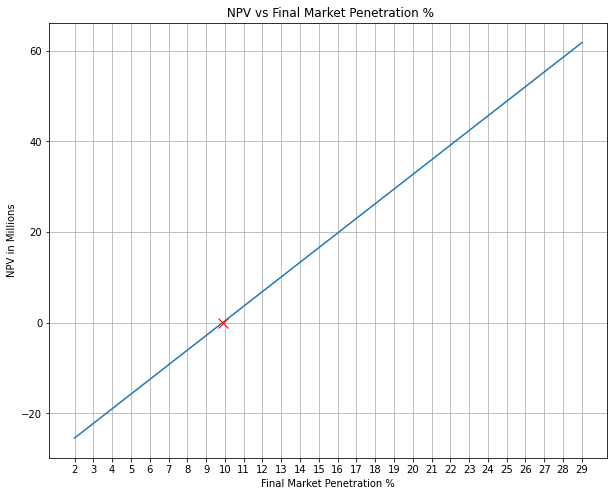

In [ ]:
#@title
# Effect of Market Penetration
array_out = []
array_in = []
for fmp in range(2,30,1):
  (df,npv) = fcn_get_npv(final_market_penetration =fmp)
  array_out.append(npv)
  array_in.append(fmp)

# Find the 0 value
f = interpolate.interp1d(array_out, array_in, assume_sorted = False)
zero_npv_fmp = f(0.0) # X vals have to be mono increasing
print(f"NPV turns 0 at a Market Penetration of: {zero_npv_fmp:.2f}%")
# print(zero_npv_fmp)

# Plotting Results
# xvals = np.linspace(0, num_years-1, num_years)
plt.figure(figsize=(10,8))
plt.plot(array_in, array_out)
ax = plt.gca()
ax.grid('on')
ax.set_xticks(array_in)
ax.set_xticklabels(array_in)

#plot zero point where NPV turns 0
plt.plot(zero_npv_fmp, 0, 'rx',markersize=10);
plt.xlabel('Final Market Penetration %')
plt.ylabel('NPV in Millions')
plt.title(" NPV vs Final Market Penetration %")
# plt.legend(["Sales"])